<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/mec647_Banquise_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fracture de la Banquise Antartique


Let $\Omega \subset (0, L)^2$, $L$ finite, being the (or one) characteristic length of the specimen.
For any 
- displacement field $u\in V_t : H^1(\Omega, R^n) + bcs(t)$ with $n=1, 2$ or $3$, and
- damage field $\alpha \in H^1(\Omega, R)$,

consider the energy $E(u, \alpha)$ defined as
$$
E_\ell(u, \alpha)=\frac{1}{2}\int_\Omega \left( a(\alpha) W(u) + k u.u \right) dx + \underbrace{\frac{G_c}{c_w\ell} \int \left(w(\alpha) + \ell^2 |\nabla \alpha|^2 \right)dx}_{\text{Surface energy}}- \int_\Omega g_t.u dx$$

In practice, $\ell \ll L$.

Above, $W$ is the elastic MEMBRANE energy density, reading (in linearised elasticity as) 
$$ 
W(u) = Ae(u):e(u) 
$$
where $A$ is the 4-th order tensor of elasticity, in the isotropic and homogeneous case, it corresponds to a linear combination with two coefficients, say, $A_0$ the stiffness (dimensional), and $\nu$ the Poisson ratio (non-dimensional), $k$ is the effective stiffness of the elastic foundation (Water/water). 

Above, $w(\alpha)$ corresponds to the dissipated energy to damage, homogeneously, the specimen, the gradient term accounts for spatial variations.

**Keypoint:** these two terms are weighted by $\ell$, a parameter that is homogeneous to a length and is understood as a *material* quantity (as opposed to *numerical*).

Define $D(\alpha_0):=\left\{ \alpha \in H^1(\Omega), \alpha \geq \alpha_0 \right\}$, for some $\alpha_0(x)\geq 0$ pointwise. 

We solve two types of problems (by increasing difficulty):
- **The static problem**: Given a load (boundary conditions) and an initial state of damage $\alpha_0$, what is the equilibrium displacement and repartition of damage?
In other terms:
 
$
\text{ min loc} \left\{ E_\ell(u, \alpha):
 u \in V_t, \alpha \in D(\alpha_0) \right\}.
$

- **The evolution problem**: Given a load **history** (boundary conditions as a function of $t$) and an initial state of damage $\alpha_0$, what is the *evolution* of equilibrium displacement and repartition of damage, i.e. 
the map $t\mapsto (u_t, \alpha_t)$, such that 
  - (Irrevers.) $\alpha_t \nearrow t$,
  - (N-Stability) $y_t$ is stable only if there exists $\bar h$ such that for $h\in (0, \bar h)$, 
  $$E_\ell (y_t) \leq E_\ell(y_t + z), \forall z \in C_{t,0}^+, ||y_t+z||\leq h$$
  - (Power statement) (Ext. power) = (Internal energy flux)


## Let'solve.


### First, setup from a clean state

In [7]:
%%time
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        # !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        # !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        # !wget https://github.com/fem-on-colab/fem-on-colab.github.io/raw/{commit}/releases/{install-script}
        !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/779acd87a4e108672d7ebd3eefd9e8e555bb51d9/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"


        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

# try:
#     import pyvista
# except ImportError:
#     !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
#     import pyvista  # noqa: F401
#     from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pip --upgrade;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install petsc4py;
!{sys.executable} -m pip install --upgrade PyYAML;
!{sys.executable} -m pip install --upgrade networkx;
!{sys.executable} -m pip install --upgrade matplotlib==3.1.3;

CPU times: user 351 ms, sys: 120 ms, total: 472 ms
Wall time: 33.6 s


In [8]:
%%time
# %%capture
!{sys.executable} -m pip install --upgrade pyvista itkwidgets;
import pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 78.5 ms, sys: 28 ms, total: 106 ms
Wall time: 6.76 s


## Install our Code, codename: _________

In [28]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD

branch_name = 'main'
branch_name = 'andres-ic3cr∀k5'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
  sys.path.append('mec647/')

  import mec647
  from mec647 import meshes
  from mec647.meshes import primitives
  from mec647.utils.viz import plot_mesh, plot_scalar, plot_vector

except Exception as e:
  print('Something went wrong', e)
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 1454, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 1454 (delta 120), reused 135 (delta 92), pack-reused 1267
Receiving objects: 100% (1454/1454), 24.79 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (751/751), done.


### Setup computational patch

In [22]:
%%capture
from dolfinx.io import XDMFFile, gmshio
from mpi4py import MPI
from pathlib import Path
gmsh.finalize()

# We parametrise the domain (target) dimension, we solve 2D for now 
tdim = 2

# Default mesh parameters are geometric

if branch_name == 'andres-plates':
  from mec647.meshes.ikea import mesh_ikea_real as slab_with_holes

#   model, tdim, tag_names = mesh_function('perforated_slab',
#                   geom_parameters={},
#                   lc=.01,
#                   tdim=2,
#                   order=0,
#                   msh_file='perforated_slab.msh'
#                   )
elif branch_name == 'main':
  from mec647.meshes import primitives

  default_parameters = {
      'geometry': {
          'geom_type': 'bar',
          'Lx': 1.,
          'Ly': 0.1
      }
  }


  gmsh_model, tdim = primitives.mesh_bar_gmshapi(
      default_parameters.get('geometry').get('geom_type'),
      default_parameters.get('geometry').get('Lx'), 
      default_parameters.get('geometry').get('Ly'), 
      lc=0.03, 
      tdim=tdim)

# Mesh on node model_rank and then distribute
model_rank = 0

from dolfinx.mesh import CellType

# Get mesh and meshtags
# mesh, mts, fts = gmshio.model_to_mesh(gmsh_model, comm, model_rank, tdim)
lc = 0.03
nc = list(map(lambda v: int(v/lc), [default_parameters.get('geometry').get('Lx'),
  default_parameters.get('geometry').get('Ly')]))


mesh = dolfinx.mesh.create_rectangle(comm, [[0.0, 0.0], [default_parameters.get('geometry').get('Lx'),
                                                         default_parameters.get('geometry').get('Ly')]],
                                     nc,
                                     cell_type=CellType.triangle)


Text(0.5, 1.0, 'Mesh with parameters, dimension 2')

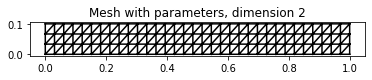

In [23]:
# Viz the mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
plt.title(f"Mesh with parameters, dimension {tdim}")
# fig.savefig(f"one_mesh.png")

In [32]:
!ls mec647/test/data/banquise

parameters.yml


In [34]:
# Let's get the entire set of parameters
import yaml

with open("mec647/test/data/banquise/parameters.yml") as f:
    parameters = yaml.load(f, Loader=yaml.FullLoader)
    

Text(0.5, 1.0, '~Computational Mesh with parameters, dimension 2')

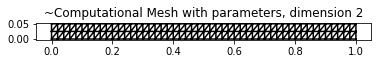

In [39]:
_lc = parameters.get('geometry').get('lc')
_ly = parameters.get('geometry').get('Ly')
_lx = parameters.get('geometry').get('Lx')

_nc = list(map(lambda v: int(v/_lc), 
              [_lx, _ly]))

mesh = dolfinx.mesh.create_rectangle(comm, [[0.0, 0.0], [_lx,_ly]],
                                     _nc,
                                     cell_type=CellType.triangle)

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
plt.title(f"~Computational Mesh with parameters, dimension {tdim}")

In [40]:
# Functional Setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")

alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Pack state
state = {"u": u, "alpha": alpha}

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")

dx = ufl.Measure("dx", domain = mesh)
ds = ufl.Measure("ds", domain = mesh)

# Useful references
Lx = parameters.get("geometry").get("Lx")
Ly = parameters.get("geometry").get("Ly")

In [41]:
# Boundary sets

from dolfinx.fem import locate_dofs_geometrical, dirichletbc


dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))

dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))

# Boundary data

u_.interpolate(lambda x: (np.ones_like(x[0]), np.zeros_like(x[1])))

# Bounds (nontrivial)

alpha_lb.interpolate(lambda x: np.zeros_like(x[0]))
alpha_ub.interpolate(lambda x: np.ones_like(x[0]))

In [42]:
# Boundary conditions

bcs_u = [
         dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
                      dofs_u_left,
                      V_u),
         dirichletbc(u_, dofs_u_right)
         ]

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_left, dofs_alpha_right]),
                         V_alpha)
]
bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}


In [43]:
import yaml


# Material behaviour
from models import BrittleMembraneOverElasticFoundation as Banquise

parameters_str = '''
# === Loading === #
loading:
    min: 0
    max: 1.001
    steps: 10

#  === Geometry === #
geometry:
    geometric_dimension: 2
    geom_type: "banquise"
    Lx: 1.
    Ly: .1
    lc: 0.02
#  === Model === #
model:
    ell: 0.1
    ell_e: 0.3
    model_dimension: 2
    model_type: "2D"
    # could be "2D"/ "3D" / "plane_stress" / "plane_strain"
# === Solver === #
solvers:
    elasticity:
        prefix: elasticity
        snes:
            snes_type: newtontr
            snes_stol: 1e-8
            snes_atol: 1e-8
            snes_rtol: 1e-8
            snes_max_it: 100
            # snes_divergence_tolerance: -1.0
            snes_monitor: ""
            ksp_type: preonly
            pc_type: lu
            pc_factor_mat_solver_type: mumps

    # Damage solver parameters
    damage:
        type: SNES
        prefix: damage
        snes:
            # Options in the case of SNES solver
            snes_type: vinewtonrsls
            snes_linesearch_type: basic
            ksp_type: preonly
            pc_type: lu
            pc_factor_mat_solver_type: mumps
            snes_atol: 1.0e-5
            snes_rtol: 1.0e-5
            # snes_stol: 0.0
            snes_max_it: 50
            # snes_divergence_tolerance: -1.0
            snes_monitor: ""
        tao:
            # Options in the case of TAO solver
            tao_type: tron
            tao_gpcg_maxpgits: 50
            tao_max_it: 100
            tao_steptol: 1.0e-7
            tao_gatol: 1.0e-8
            tao_grtol: 1.0e-8
            tao_gttol: 1.0e-8
            tao_catol: 0.
            tao_crtol: 0.
            tao_ls_ftol: 1e-5
            tao_ls_gtol: 1e-5
            tao_ls_rtol: 1e-5
            ksp_rtol: 1e-6
            tao_ls_stepmin: 1e-8
            tao_ls_stepmax: 1e6
            pc_type: lu
            tao_monitor: ""

    # Damage Elasticity Solver parameters
    damage_elasticity:
        max_it: 100
        alpha_rtol: 1.0e-5
        criterion: "alpha_H1"
'''
parameters = yaml.load(parameters_str, Loader=yaml.FullLoader)

model = Banquise(parameters["model"])


# Energy functional
from dolfinx.fem import (
    Constant)

# trace of geostrophic forces 
gt = dolfinx.fem.Function(V_u, name="Geostrophic")
# gt = Constant(mesh, np.array([0, 0], dtype=PETSc.ScalarType))
external_work = ufl.dot(gt, state["u"]) * dx
total_energy = model.total_energy_density(state) * dx - external_work

# total_energy = model.total_energy_density(state) * dx


In [44]:
# Evolution solver
import algorithms
from algorithms import am

solver = am.AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [45]:
%%time
# Loop for evolution
from dolfinx.fem import assemble_scalar


loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

data = {
    'elastic': [],
    'foundation': [],
    'membrane': [],
    'surface': [],
    'total': [],
    'load': []
}
for (i_t, t) in enumerate(loads):

  # update loads (body)
  gt.interpolate(lambda x: (0. * np.ones_like(x[0]), np.zeros_like(x[1])))
  gt.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update loads (boundary conditions)
  u_.interpolate(lambda x: (0 * np.ones_like(x[0]), np.zeros_like(x[1])))
  u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # solve for current load step
  print(f"Solving timestep {i_t}, load: {t}")

  solver.solve()

  # postprocessing
  # global

  surface_energy = comm.allreduce(
          assemble_scalar(
            dolfinx.fem.form(model.damage_dissipation_density(state) * dx)),
          op=MPI.SUM
          )

  foundation_energy = comm.allreduce(
      assemble_scalar(dolfinx.fem.form(model.elastic_foundation_density(u) * dx)),
      op=MPI.SUM,
  )

  elastic_energy = comm.allreduce(
      assemble_scalar(
        dolfinx.fem.form(model.elastic_energy_density(state) * dx)),
          op=MPI.SUM
        )
  
  data.get('elastic').append(elastic_energy)
  data.get('surface').append(surface_energy)
  data.get("foundation").append(foundation_energy)
  data.get("membrane").append(elastic_energy - foundation_energy)
  data.get('total').append(surface_energy+elastic_energy)
  data.get('load').append(t)

  print(f"Solved timestep {i_t}, load: {t}")
  print(f"Elastic Energy {elastic_energy:.3g}, Surface energy: {surface_energy:.3g}")
  print("\n\n")

  # savings?


Solving timestep 0, load: 0.0
  0 SNES Function norm 1.979899007121e-01 
  1 SNES Function norm 3.688918478703e-02 
  2 SNES Function norm 6.861541126086e-17 
  0 SNES Function norm 2.758573065692e-04 
  1 SNES Function norm 1.120567290585e-04 
  2 SNES Function norm 3.767130775773e-05 
  3 SNES Function norm 1.550695323478e-05 
  4 SNES Function norm 1.756021632926e-19 
  0 SNES Function norm 2.737921149485e-04 
  1 SNES Function norm 6.149089144538e-17 
  0 SNES Function norm 2.129704727929e-05 
  1 SNES Function norm 1.574057373690e-05 
  2 SNES Function norm 1.325867207096e-05 
  3 SNES Function norm 8.421458841677e-06 
  0 SNES Function norm 7.879368200297e-05 
  1 SNES Function norm 6.828464808701e-17 
  0 SNES Function norm 1.097234480415e-05 
  1 SNES Function norm 2.217314389641e-07 
  0 SNES Function norm 3.955436025924e-05 
  1 SNES Function norm 6.840368282657e-17 
  0 SNES Function norm 3.711606958659e-06 
Solved timestep 0, load: 0.0
Elastic Energy 0.0257, Surface energy:

KeyboardInterrupt: ignored

([<matplotlib.axis.XTick at 0x7f032af3e890>,
 [Text(0, 0, '0'), Text(0, 0, '1')])

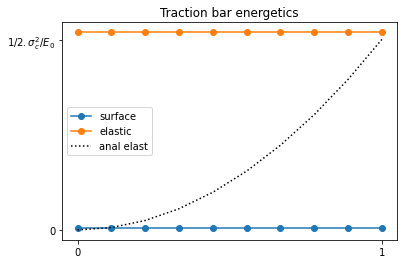

In [ ]:
plt.plot(data.get('load'), data.get('surface'), label='surface', marker='o')
plt.plot(data.get('load'), data.get('elastic'), label='elastic', marker='o')
plt.plot(data.get('load'), [1./2. * t**2*Ly for t in data.get('load')], label='anal elast', ls=':', c='k')

plt.title('Traction bar energetics')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])

In [ ]:
# experiments
params0, data0 = parameters, data


This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  '\n'



Text(0.5, 1.0, 'Traction bar damage profile')

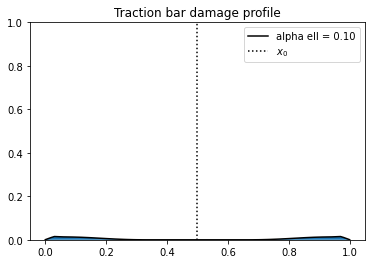

In [ ]:
from mec647.utils.viz import plot_vector, plot_scalar, plot_profile
plotter = pyvista.Plotter(
    title="Damage profile",
    window_size=[800, 600],
    shape=(1, 1),
)
_ell = parameters.get('model').get('ell')
tol = 1e-3
xs = np.linspace(0 + tol, Lx - tol, 101)
points = np.zeros((3, 101))
points[0] = xs

_plt, data = plot_profile(
    alpha,
    points,
    plotter,
    subplot=(0, 0),
    lineproperties={
        "c": "k",
        # "label": f"$\alpha$ with $\ell$ = {_ell:.2f}"
        "label": f"alpha ell = {_ell:.2f}"
    },
)
ax = _plt.gca()
# ax.axvline(Lx/2 - 2*_ell, c="k")
# ax.axvline(Lx/2 + 2*_ell, c="k", label='|supp|=$4\ell$')
ax.axvline(Lx/2 , c="k", ls=':', label='$x_0$')
_plt.legend()
_plt.fill_between(data[0], data[1].reshape(len(data[1])))
_plt.ylim([0,1])
_plt.title("Traction bar damage profile")
